In [1]:
from importlib.metadata import version

print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

torch version: 2.5.1
tiktoken version: 0.8.0


### We are here

* Data Preparation and sampling to get input data ready for LLM

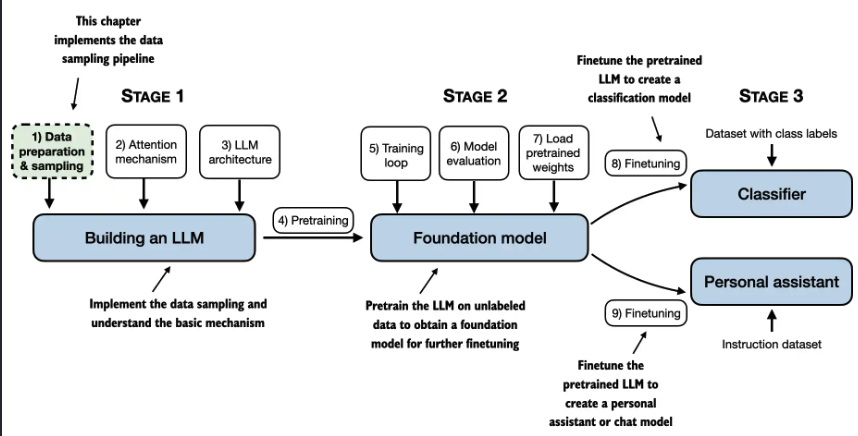

## 1. Understanding word Embeddings

Embeddings are vector representation of descrete objects into dense representations, for example words, texts, paragraphs, etc

They are usually a pretrained neural network model. 

One of the earliest is `Word2Vec` [link](https://arxiv.org/abs/1301.3781)

## 2. Text Tokenisation

In a nutshell, Tokenisation is process of breaking text into smaller units.



In [2]:
import os
import urllib.request

if not os.path.exists("the-verdict.txt"):
    url = (
        "https://raw.githubusercontent.com/rasbt/"
        "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
        "the-verdict.txt"
    )
    file_path = "the-verdict.txt"
    urllib.request.urlretrieve(url, file_path)

In [3]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

In [4]:
print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


### 2.1 Develping Simple Tokenizer using regex expression

In [5]:
import re

text = "Hello, world. This, is a test."
result = re.split(r"(\s)", text)

print(result)

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


* Splitting on commas and periods, needs to be done

* Case is preserved as to make LLM aware of proper nowns & common nouns, understanding sentence strucrure

In [6]:
result = re.split(r"([,.]|\s)", text)

print(result)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


* Above still contains whitespace chracters, optionally this can be removed. 
  
  a.) In Coding whitespaces would be required 

> keeping whitespaces can be useful if we train models that are sensitive to the exact structure of the text (for example, Python code, which is sensitive to indentation and spacing). Here, we remove whitespaces for simplicity and brevity of the tokenized outputs. Later, we will switch to a tokenization scheme that includes whitespaces.`

In [7]:
result = [item for item in result if item.strip()]
result

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']

* Adding punctuation marks into tokenisation process

In [8]:
text = "Hello, world. Is this-- a test?"
result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


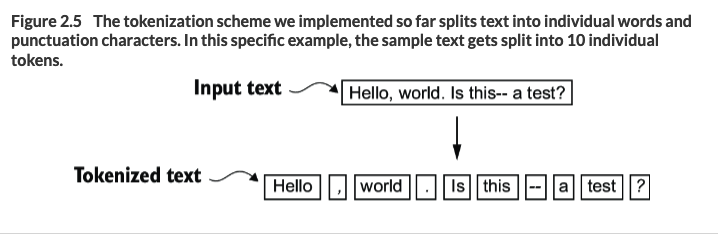

### 2.2. Tokening entire Short Story

In [9]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(len(preprocessed))

4690


In [10]:
len(set(preprocessed))

1130

In [11]:
## Looking at first 30 tokens
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


## 3. Converting tokens into token IDs

A vocabulary is created which basically a dictionary which maps tokens (Str )to Token IDs (Integer) representation. 
> This is essentially size of unique tokens in training data

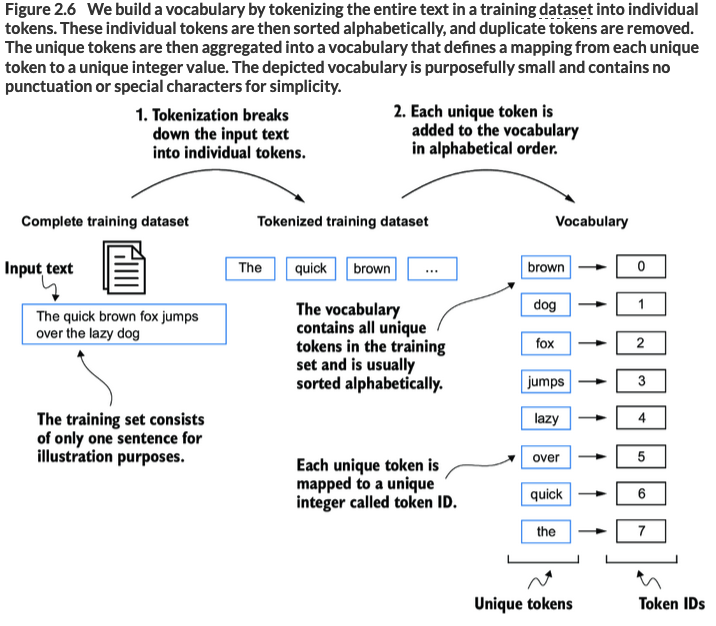

In [12]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)
print(vocab_size)

1130


### 3.1. Creating Vocabulary

Vocabulary is built on entire training data. So it's crucial to create right set of Vocabulary matching the use case

In [13]:
## encoding (str -> integer)
vocab = {token: integer for integer, token in enumerate(all_words)}

In [14]:
for i, item in enumerate(vocab.items()):
    print(item)

    if i >= 10:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)


### 3.2. Implementing Simple Text Tokenizer

In [15]:
class SimpleTokenizerV1:

    def __init__(self, vocab: dict):
        self.str_to_int = vocab
        self.int_to_str = {i: s for s, i in vocab.items()}

    def encode(self, text: str):

        tokens_with_space = re.split(r'([,.?_!"()\']|--|\s)', text)

        tokens_space_removed = [
            item.strip() for item in tokens_with_space if item.strip()
        ]

        ids = [self.str_to_int[s] for s in tokens_space_removed]

        return ids

    def decode(self, ids: list[int]):

        decoded_text = " ".join([self.int_to_str[i] for i in ids])

        ## removing spaces before specified punctuation

        decoded_text = re.sub(r'\s+([,.?!"()\'])', r"\1", decoded_text)

        return decoded_text

#### 3.2.1 Test Sample 1

In [16]:
text_tokeniser = SimpleTokenizerV1(vocab=vocab)

text = """"It's the last he painted, you know," 
       Mrs. Gisburn said with pardonable pride."""
ids = text_tokeniser.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


#### 3.2.2 Test Sample 2

This test sample, will fail as `Hello` is not present in the short story!

> This highlights the need to consider large and diverse training sets to extend the vocab

In [17]:
text = "Hello, do you like tea?"
print(text_tokeniser.encode(text=text))

KeyError: 'Hello'

### 3.3. Adding Special Context Tokens

To deal with certain contexts, we need to add special tokens to understand.
Let's add 2 special tokens

 * document boundaries: `<|endoftext|>` [To separate two unrelated text sources]
 * Unknown Token in text: `<|unk|>`
 

 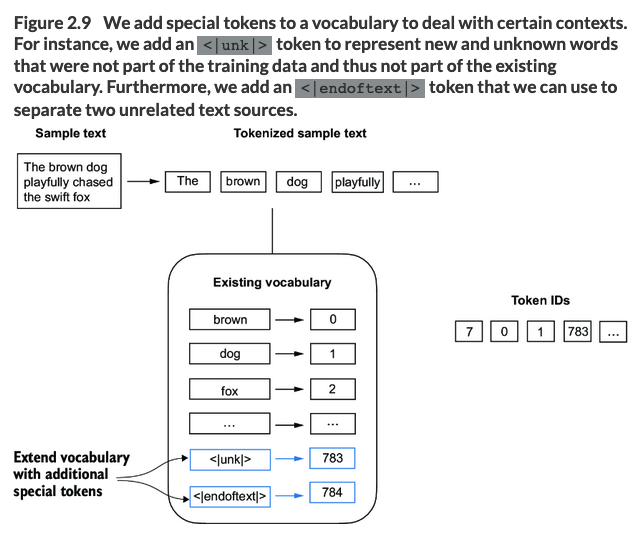



During training phase multiple text are concatenated from various sources and `<|endoftext|>` tokens act as markers, signaling the start or end of a particular segment, allowing for more effective processing. 

This signals LLM understand that although these text sources are concatenated for training, they are in fact unrelated


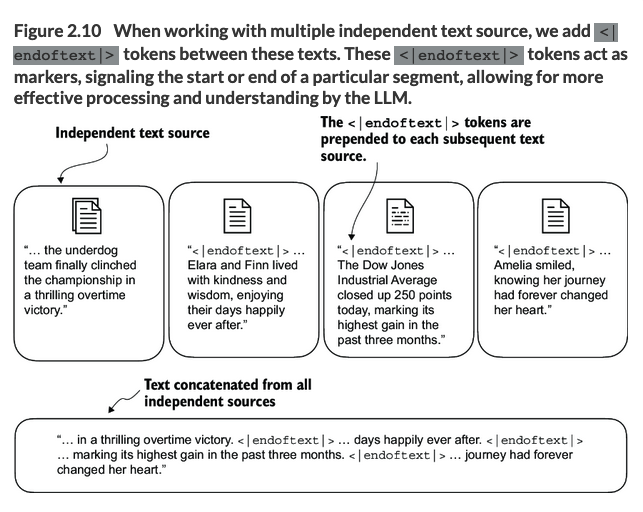
 

In [18]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])

vocab = {token: integer for integer, token in enumerate(all_tokens)}

In [19]:
print(len(vocab))

1132


#### 3.3.1. Implementing Tokeniser which handles unknown words

In [20]:
class SimpleTokenizerV2:

    def __init__(self, vocab: dict):
        self.str_to_int = vocab
        self.int_to_str = {i: s for s, i in vocab.items()}

    def encode(self, text: str):

        tokens_with_space = re.split(r'([,.?_!"()\']|--|\s)', text)

        tokens_space_removed = [
            item.strip() for item in tokens_with_space if item.strip()
        ]

        ## replacing unknown tokens with <|unk|>
        tokens_space_removed = [
            s if s in self.str_to_int else "<|unk|>" for s in tokens_space_removed
        ]

        ids = [self.str_to_int[s] for s in tokens_space_removed]

        return ids

    def decode(self, ids: list[int]):

        decoded_text = " ".join([self.int_to_str[i] for i in ids])

        ## removing spaces before specified punctuation

        decoded_text = re.sub(r'\s+([,.?!"()\'])', r"\1", decoded_text)

        return decoded_text

In [21]:
text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."

text = " <|endoftext|> ".join((text1, text2))

print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [22]:
tokenizer = SimpleTokenizerV2(vocab=vocab)
print(tokenizer.encode(text=text))

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]


In [23]:
print(tokenizer.decode(tokenizer.encode(text)))

<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.


#### 3.3.2. Other Special Tokens used in Research

* Beginning of sequence `[BOS]`: Marks the start of a text. It signifies to the LLM where a piece of content begins

* End of sequence `[EOS]`: This positioned at the end of a text and used especially **useful** when concatenating multiple unrelated texts, similar to `<|endoftext|>`

> Like for combining two different Wikipedia articles or books, the `[EOS]` token indicates where one ends and the next begins

* Padding `[PAD]`: When Batch is more than 1, one batch might contain texts of varying lengths.

### 3.4 Byte Pair Encoding

In [24]:
import tiktoken

In [25]:
tokenizer = tiktoken.get_encoding("gpt2")

In [ ]:
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
    "of someunknownPlace."
)
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(integers)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (4108449770.py, line 2)

In [26]:
strings = tokenizer.decode(integers)
print(strings)

Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


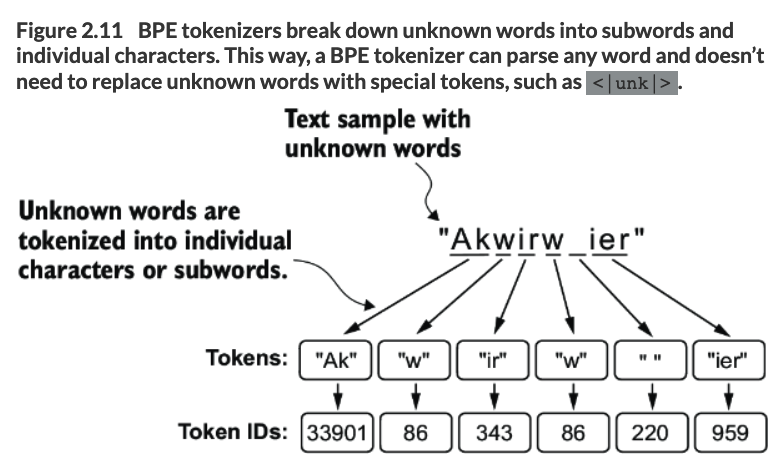

In [28]:
text_check = "Akwirw ier"

encoded_repr = tokenizer.encode(text_check)

decoder_repr = tokenizer.decode(encoded_repr)

In [29]:
for token_id in encoded_repr:
    print(f"{tokenizer.decode([token_id])} --> {token_id}")

Ak --> 33901
w --> 86
ir --> 343
w --> 86
  --> 220
ier --> 959


In [30]:
decoder_repr

'Akwirw ier'

### 3.5. Data Sampling with Sliding Window

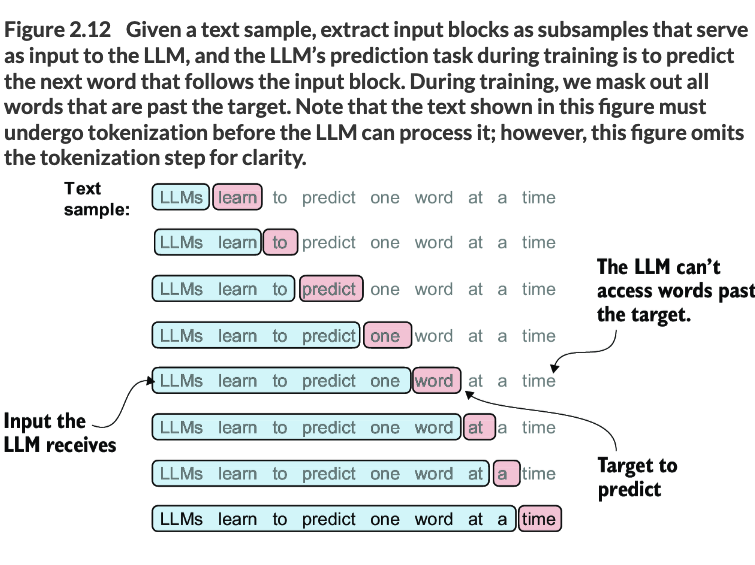

In [30]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

enc_text = tokenizer.encode(raw_text)

In [31]:
enc_sample = enc_text[50:]

In [32]:
len(enc_sample)

5095

In [33]:
context_size = 4
x = enc_sample[:context_size]
y = enc_sample[1 : context_size + 1]

In [34]:
print(f"x: {x}")
print(f"y:      {y}")

x: [290, 4920, 2241, 287]
y:      [4920, 2241, 287, 257]


In [35]:
tokenizer.decode(enc_sample[: context_size + 1])

' and established himself in a'

In [36]:
for i in range(1, context_size + 1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(tokenizer.decode(context), "----->", tokenizer.decode([desired]))

 and ----->  established
 and established ----->  himself
 and established himself ----->  in
 and established himself in ----->  a


#### 3.5.1 Implementing Efficient Data Loader

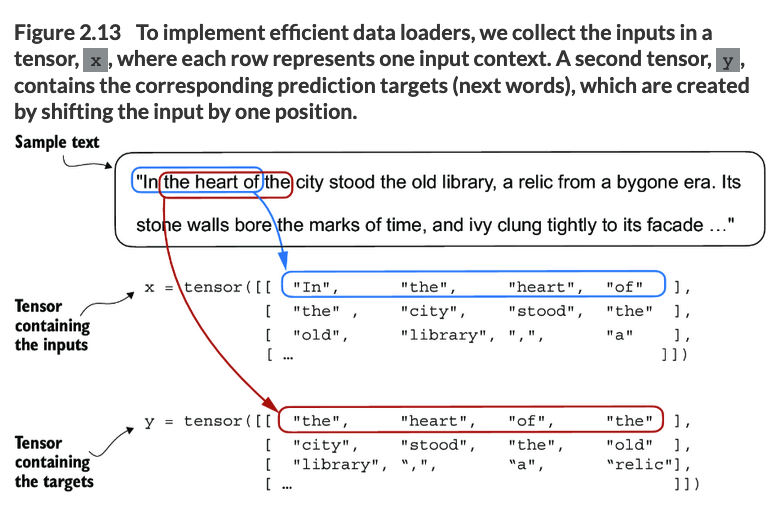



In [37]:
import torch
from torch.utils.data import DataLoader, Dataset

In [38]:
class GPTDatasetV1(Dataset):

    def __init__(self, text, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(text)

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i : i + max_length]
            target_chunk = token_ids[i + 1 : i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [39]:
def create_dataloader_v1(
    txt,
    batch_size=4,
    max_length=256,
    stride=128,
    shuffle=True,
    drop_last=True,
    num_workers=0,
):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
    )

    return dataloader

In [40]:
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False
)

In [41]:
dataset_obj = GPTDatasetV1(raw_text, tokenizer, max_length=4, stride=1)

In [42]:
dataset_obj.__len__()

5141

In [62]:
dataset_obj[0]

(tensor([  40,  367, 2885, 1464]), tensor([ 367, 2885, 1464, 1807]))

In [43]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=8, stride=2, shuffle=False
)

In [44]:
data_iter = iter(dataloader)

In [45]:
next(data_iter)

[tensor([[  40,  367, 2885, 1464, 1807, 3619,  402,  271]]),
 tensor([[  367,  2885,  1464,  1807,  3619,   402,   271, 10899]])]

In [46]:
next(data_iter)

[tensor([[ 2885,  1464,  1807,  3619,   402,   271, 10899,  2138]]),
 tensor([[ 1464,  1807,  3619,   402,   271, 10899,  2138,   257]])]

In [47]:
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=4, stride=4, shuffle=False
)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


### 3.6. Creation of Token Embeddings

In [48]:
inout_ids = torch.tensor([2, 3, 5, 1])

vocab_size = 6
output_dim = 3

In [49]:
torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [50]:
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


In [51]:
embedding_layer(torch.tensor([3]))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)

In [54]:
tiktoken.get_encoding("gpt2s")

ValueError: Unknown encoding gpt2s.
Plugins found: ['tiktoken_ext.openai_public']
tiktoken version: 0.8.0 (are you on latest?)